In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2853.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2842.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2829.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2784.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2797.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2803.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2851.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2821.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2795.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2852.jpg
/kaggle/input/abstract-art-gal

In [2]:
import os

DATA_DIR = '../input/abstract-art-gallery'
print(os.listdir(DATA_DIR))

['Abstract_gallery_2', 'Abstract_gallery']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images,nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_xticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

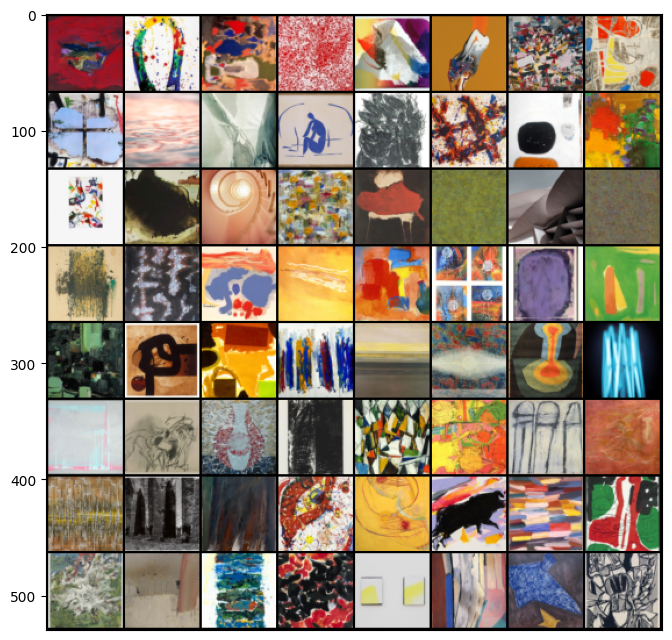

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

**Configure Data Loader**

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
import torch.nn as nn

**discriminator**

In [14]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

In [16]:
latent_size = 128

**generator**

In [17]:
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


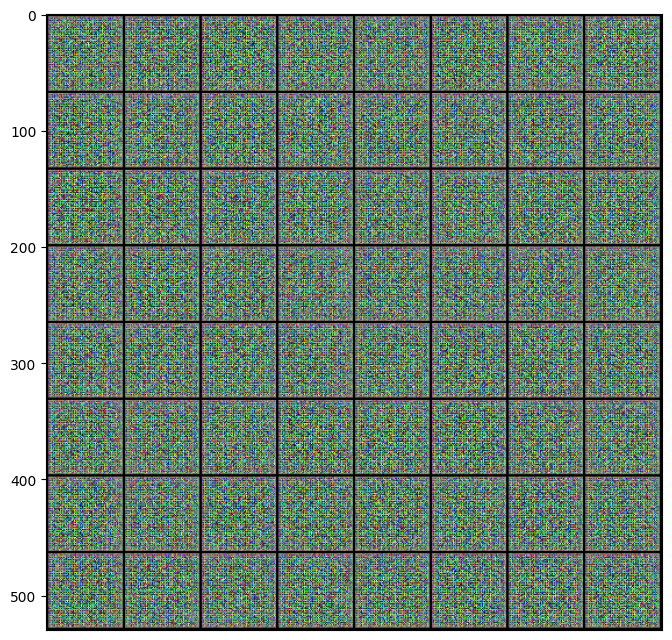

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [21]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
from torchvision.utils import save_image

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
lr = 0.0002
epochs = 5

In [28]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 5

In [30]:
history = fit(epochs, lr)

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 11.4337, loss_d: 1.2437, real_score: 0.8621, fake_score: 0.6520
Saving generated-images-0001.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 5.8338, loss_d: 0.6329, real_score: 0.8140, fake_score: 0.3245
Saving generated-images-0002.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 1.8923, loss_d: 0.6095, real_score: 0.8965, fake_score: 0.3797
Saving generated-images-0003.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 5.0110, loss_d: 0.3080, real_score: 0.9146, fake_score: 0.1820
Saving generated-images-0004.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 4.6282, loss_d: 0.2668, real_score: 0.8763, fake_score: 0.1125
Saving generated-images-0005.png


In [31]:
losses_g, losses_d, real_scores, fake_scores = history

In [32]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [33]:
from IPython.display import Image

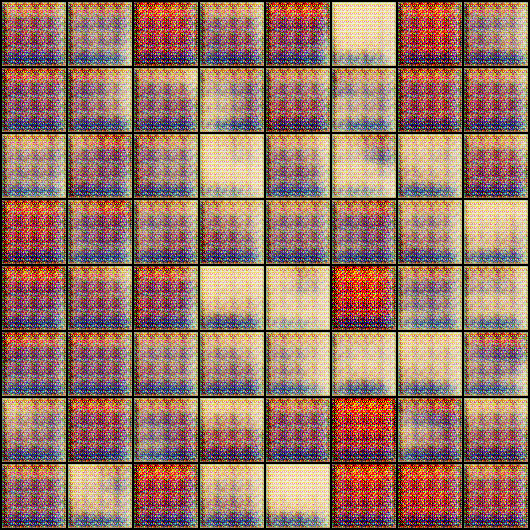

In [34]:
Image('./generated/generated-images-0005.png')

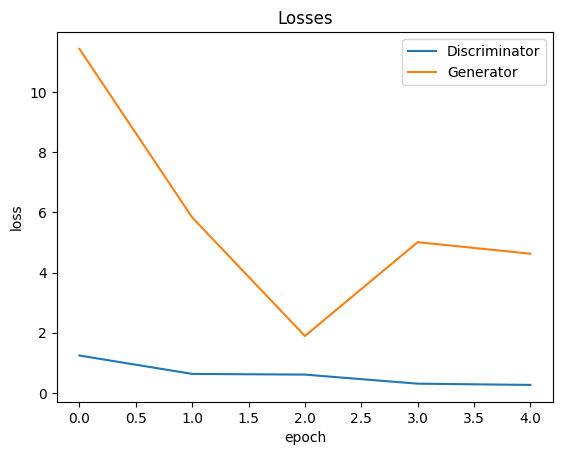

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

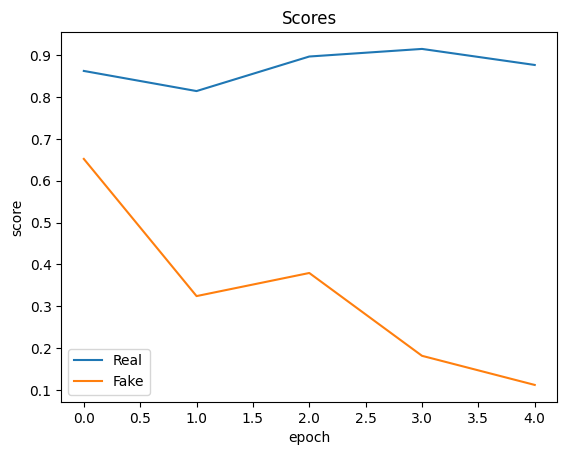

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');